In [13]:
import numpy as np
from matplotlib import pyplot as plt
from tf_keras_vis.utils.scores import CategoricalScore

from tf_keras_vis.gradcam import Gradcam

import numpy as np
import cv2
import os
import itertools

from tensorflow import keras

from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

DIR_DATA = 'Final_dataset_small2'
classes = os.listdir(DIR_DATA)
print(classes)

DIR_MODEL = 'models/xception_fine_no_freeze_flatten.h5'

replace2linear = ReplaceToLinear()

model = keras.models.load_model(DIR_MODEL)

saliency = Saliency(model,
                    model_modifier=replace2linear,
                    clone=True)

gradcam = Gradcam(
    model,
    model_modifier=ReplaceToLinear(),
    clone=True
)

def load_image(path):
    img_array = cv2.imread(path)
    img_array = img_array / 255.0
    return img_array

def square_contains_points(square, points):
    x1, y1, x2, y2 = square
    return all(x1 <= x <= x2 and y1 <= y <= y2 for x, y in points)

def square_contains_at_most_b_points(square, points, max_b_points):
    x1, y1, x2, y2 = square
    count = sum(1 for x, y in points if x1 <= x <= x2 and y1 <= y <= y2)
    return count <= max_b_points

def find_largest_square(a, b, max_b_points):
    points = np.concatenate([a, b], axis=0)
    x_values = sorted(set(points[:, 0]))
    y_values = sorted(set(points[:, 1]))
    
    largest_square = None
    largest_size = 0
    
    for x1, x2 in itertools.combinations(x_values, 2):
        for y1, y2 in itertools.combinations(y_values, 2):
            square = (x1, y1, x2, y2)
            size = (x2 - x1) * (y2 - y1)
            if size > largest_size and square_contains_points(square, a) and square_contains_at_most_b_points(square, b, max_b_points):
                largest_square = square
                largest_size = size
    
    return largest_square


def grad_cam_hirechical(img, n=3, class_index=6, weight=1):
    height, width, _ = img.shape

    # Padding
    if height % n != 0:
        img = np.concatenate([img, np.zeros((n - height % n, width, 3))], axis=0)
        img = np.concatenate([np.zeros((n, width, 3)), img], axis=0)


    grid_height, grid_width = height // n, width // n
    images = []
    for i in range(n):
        for j in range(n):
            images.append(img[i * grid_height:(i + 1) * grid_height, j * grid_width:(j + 1) * grid_width])

    images = np.array(images)

    # Crea 4 imagenes por cada 

    # Aplicar Grad-CAM a cada imagen, redimensionar antes de hacer Grad-CAM
    images_grad = []
    for i in range(n ** 2):
        images_grad.append(cv2.resize(images[i], (width, height)))

    images_grad = np.array(images_grad)

    cam = gradcam(CategoricalScore(class_index), images_grad, penultimate_layer=-1)

    # Redimensionar las imagenes de Grad-CAM a grid_height x grid_width
    cam = np.array([cv2.resize(cam[i], (grid_width, grid_height)) for i in range(n ** 2)])

    # Agrupar las 4 imágenes Grad-CAM

    cam = np.concatenate([np.concatenate(cam[i * n:(i + 1) * n], axis=1) for i in range(n)], axis=0)
    cam = cv2.resize(cam, (width, height))
    cam = np.power(cam, 2)
    #cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam)) * weight
    return cam

for class_index, class_ in enumerate(classes[1:]):
    print(f'{class_index} - {class_}')
    class_index = class_index + 1
    imagenes = os.listdir(os.path.join(DIR_DATA, class_))
    for j, img in enumerate(imagenes):
        if img.endswith('.npy'): continue
        try:
            print(f'{j} - {img}')
            img_array = load_image(os.path.join(DIR_DATA, class_, img))

            cams = []
            weight = 1
            for i in range(1, 4):
                cams.append(grad_cam_hirechical(img_array, n=i, class_index=class_index, weight=weight))
                #weight *= 0.8

            cams = np.array(cams)
            mean_cam = np.mean(cams, axis=0)
            cam1 = mean_cam
            cam1 = (cam1 - np.min(cam1)) / (np.max(cam1) - np.min(cam1))
            cam1 = (cam1 * 255).astype(np.uint8)
            heatmap = cam1

            saliency_map = saliency(CategoricalScore(class_index), img_array, smooth_samples=50, smooth_noise=0.20)

            # Normalizes saliency map to 0-255, std
            saliency_map_ = saliency_map[0].copy()
            saliency_map_2 = saliency_map[0].copy()

            indices_f_m1 = np.arange(0, saliency_map_.shape[0], 1)
            indices_c_m1 = np.arange(0, saliency_map_.shape[1], 1)

            indices_f_m2 = np.arange(5, saliency_map_.shape[0], 10)
            indices_c_m2 = np.arange(5, saliency_map_.shape[1], 10)

            # Crear una malla de coordenadas basada en indices_f y indices_c
            f_m1, c_m1 = np.meshgrid(indices_f_m1, indices_c_m1, indexing='ij')
            f_m2, c_m2 = np.meshgrid(indices_f_m2, indices_c_m2, indexing='ij')

            # Crear una máscara booleana donde True corresponde a los puntos que son mayores a 127

            tmp_mask = heatmap[f_m1, c_m1] > 190
            tmp_mask2 = heatmap[f_m2, c_m2] <= 20

            saliency_map_ = saliency_map_ - np.min(saliency_map_[heatmap > 190])
            saliency_map_ = saliency_map_ / np.max(saliency_map_[heatmap > 190])
            saliency_map_ = saliency_map_ * 255

            saliency_map_2 = saliency_map_2 - np.min(saliency_map_2[heatmap <= 40])
            saliency_map_2 = saliency_map_2 / np.max(saliency_map_2[heatmap <= 40])
            saliency_map_2 = saliency_map_2 * 255

            mask = saliency_map_[f_m1, c_m1] > 190
            mask2 = saliency_map_2[f_m2, c_m2] <= 100

            mask = np.logical_and(mask, tmp_mask)
            mask2 = np.logical_and(mask2, tmp_mask2)

            # Aplicar la máscara a las matrices de coordenadas
            points_f = f_m1[mask]
            points_c = c_m1[mask]

            points_f2 = f_m2[mask2]
            points_c2 = c_m2[mask2]

            points = np.stack([points_c, points_f], axis=-1)
            points2 = np.stack([points_c2, points_f2], axis=-1)

            square = find_largest_square(points, points2, max_b_points=20)

            # Quitar puntos points2 que estan dentro del cuadrado
            mask = np.logical_and(points2[:, 0] >= square[0], points2[:, 0] <= square[2])
            mask = np.logical_and(mask, points2[:, 1] >= square[1])
            mask = np.logical_and(mask, points2[:, 1] <= square[3])

            points2 = points2[~mask]

            points = np.stack([points_c, points_f], axis=-1)
            points2 = np.stack([points_c2, points_f2], axis=-1)

            labels = np.zeros(points.shape[0], dtype=np.int32)
            labels2 = np.ones(points2.shape[0], dtype=np.int32)

            labels = np.concatenate([labels2, labels])
            points = np.concatenate([points2, points])

            # Save the points and labels to a file
            np.save(os.path.join(DIR_DATA, class_, img.replace('.jpg', '.npy')), points)
            np.save(os.path.join(DIR_DATA, class_, img.replace('.jpg', '_labels.npy')), labels)
        except Exception as e:
            print(e)

['Amarillo', 'Azul', 'Marron', 'Medicamento', 'Pilas', 'Punto', 'RAEE', 'Resta', 'Ropa', 'Verde']
0 - Azul
0 - 020172_00_1.jpg
3 - 167164_00_1.jpg
6 - 1990_20230331_140945_AZUL_NONE.jpg
9 - 1paper.png
11 - 2439_20230331_144903_AZUL_NONE.jpg
14 - 262789_00_1.jpg
17 - 290377_00_1.jpg
20 - 2906_20230331_184840_AZUL_NONE.jpg
23 - 3627_20230330_201128_AZUL_NONE.jpg
26 - 3684_20230401_174339_AZUL_NONE.jpg
29 - 3705_20230327_000745_AZUL_NONE.jpg
32 - 371164_00_1.jpg
35 - 3847_20230330_195918_AZUL_NONE.jpg
38 - 4459_20230331_145624_AZUL_NONE.jpg
41 - 5109_20230331_184826_AZUL_NONE.jpg


C:\Users\Juanma\AppData\Local\Temp\ipykernel_6032\2833629415.py:77: RuntimeWarning: invalid value encountered in divide
  cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam)) * weight


zero-size array to reduction operation minimum which has no identity
42 - 5258_20230330_230802_AZUL_NONE.jpg
45 - 559181_00_1.jpg
48 - 5682_20230330_184635_AZUL_NONE.jpg
51 - 569855_00_1.jpg
54 - 5875_20230330_195620_AZUL_NONE.jpg
57 - 5984_20230402_191609_AZUL_NONE.jpg
60 - 6054_20230330_120855_AZUL_NONE.jpg
63 - 6912_20230331_140821_AZUL_NONE.jpg
66 - bag-2771100__340.jpg
69 - cardboard10.jpg
72 - cardboard130.jpg
73 - cardboard132.jpg
76 - cardboard143.jpg
79 - cardboard167.jpg
82 - cardboard191.jpg
85 - cardboard195.jpg
88 - cardboard203.jpg
91 - cardboard238.jpg
94 - carton (100).jpg
97 - garbage-bin-paper-waste-against-background-13074817.jpg
98 - garbage-bin-paper-waste-isolated-13336029.jpg
101 - IMG20230220104832.jpg
104 - IMG20230220104836.jpg
107 - IMG20230220104844.jpg
110 - IMG20230220112833.jpg
113 - IMG20230220115400.jpg
116 - IMG20230220115658.jpg
119 - IMG20230220120130.jpg
122 - IMG20230220120140.jpg
125 - IMG20230220120944.jpg
128 - IMG20230220122950.jpg
129 - IMG202

In [5]:
from segment_anything import SamPredictor, sam_model_registry
sam = sam_model_registry["vit_h"](checkpoint="sam_vit_h_4b8939.pth")
#sam.to("cuda")

predictor = SamPredictor(sam)

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    # mask_image to binary
    mask_image = mask_image[:, :, 0] > 0
    ax.imshow(mask_image)
    return mask_image

def show_points(coords, labels, ax, marker_size=20):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

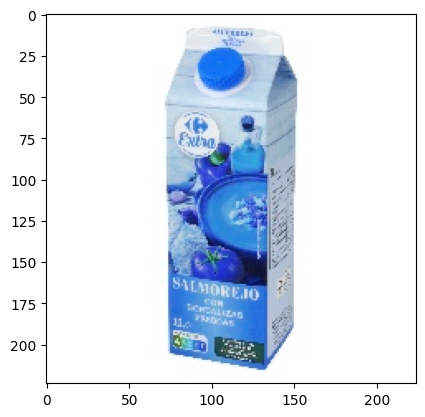

In [8]:
plt.imshow(img_array)
plt.show()

In [ ]:
img = (img_array * 255).astype(np.uint8)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
predictor.set_image(img,image_format = 'RGB')

# Read points and labels
points = np.load(r'Final_dataset_small2\Amarillo\004270_00_1.npy'.replace('\\', '/'))
labels = np.load(r'Final_dataset_small2\Amarillo\004270_00_1_labels.npy'.replace('\\', '/'))

# Predict the mask
masks, C, low = predictor.predict(point_coords=np.expand_dims(points[0], axis=0), point_labels=np.expand_dims(labels[0], axis=0), multimask_output=False)
final_mask = masks[0]
points_new = [points[0]]
labels_new = [labels[0]]
index = 0
for point, label in zip(points[1:], labels[1:]): 
    points_new.append(point)
    labels_new.append(label)
    masks, C, low = predictor.predict(point_coords=np.array(points_new), point_labels=np.array(labels_new), multimask_output=False, mask_input = low)
    masks = masks[0]
    index += 1
    plt.title(f"Point: {label}")
    plt.imshow(masks)
    plt.show()